In [12]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

data = pd.read_csv(r"face_similarity_scores(original_mtcnn+retina).csv")

df = data.copy()

df.head()

,case_no,facenet_score,arcface_score,facenet_label,arcface_label,lvface_label,lvface_score
0,1,0.7931,0.4748,1,0,1,0.5288
1,2,0.5635,0.4882,0,0,0,-0.0711
2,3,0.0972,0.1828,0,0,0,0.1025
3,4,0.8226,0.6481,1,1,0,-0.0503
4,5,0.4305,0.3766,0,0,0,-0.0155


FACE MATCH RESULT dataset

In [13]:
# reset index biar rapi
df = df.reset_index(drop=True)

df.head()

,case_no,facenet_score,arcface_score,facenet_label,arcface_label,lvface_label,lvface_score
0,1,0.7931,0.4748,1,0,1,0.5288
1,2,0.5635,0.4882,0,0,0,-0.0711
2,3,0.0972,0.1828,0,0,0,0.1025
3,4,0.8226,0.6481,1,1,0,-0.0503
4,5,0.4305,0.3766,0,0,0,-0.0155


       facenet_score  arcface_score  lvface_score
count     100.000000     100.000000    100.000000
mean        0.357161       0.301261      0.232512
std         0.320983       0.242343      0.258663
min        -0.234800      -0.074800     -0.114300
25%         0.081650       0.093575      0.004075
50%         0.304550       0.191950      0.089800
75%         0.653875       0.511600      0.497525
max         0.908900       0.779600      0.707600

Distribusi label (setelah update):
Facenet: {1: 50, 0: 50}
ArcFace: {1: 50, 0: 50}
LVFace: {0: 56, 1: 44}


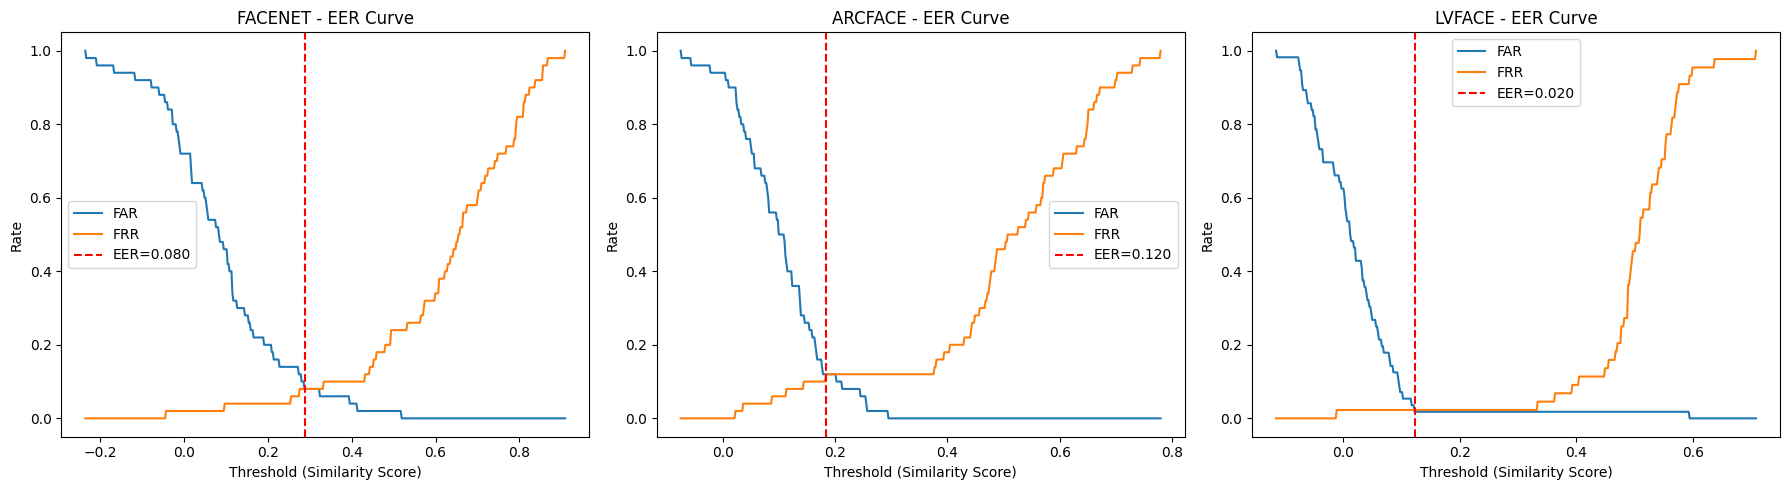

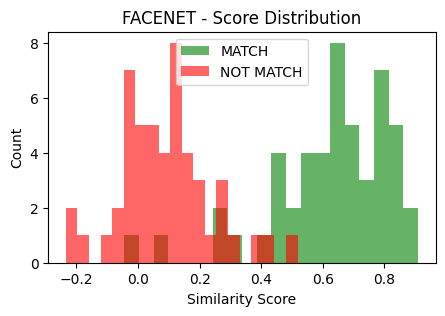

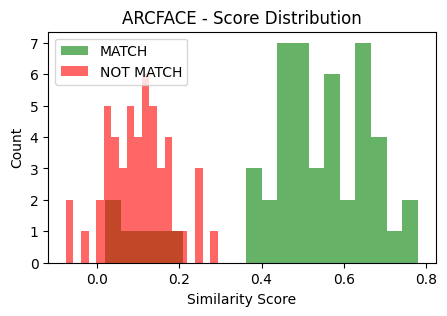

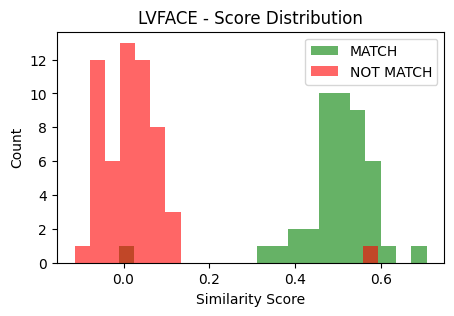


=== DEBUG SCORE RANGE ===
FACENET:
  MATCH mean: 0.6251
  NOT MATCH mean: 0.0893
  MATCH range: -0.0444 → 0.9089
  NOT MATCH range: -0.2348 → 0.5180

ARCFACE:
  MATCH mean: 0.4990
  NOT MATCH mean: 0.1035
  MATCH range: 0.0211 → 0.7796
  NOT MATCH range: -0.0748 → 0.2941

LVFACE:
  MATCH mean: 0.5007
  NOT MATCH mean: 0.0218
  MATCH range: -0.0112 → 0.7076
  NOT MATCH range: -0.1143 → 0.5931


=== HASIL AKHIR (FAR, FRR, EER) ===
     Model     EER  Threshold_EER  FAR@EER  FRR@EER Note
0  FACENET  0.0800         0.2878   0.0800   0.0800     
1  ARCFACE  0.1200         0.1837   0.1200   0.1200     
2   LVFACE  0.0203         0.1229   0.0179   0.0227     


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1️⃣ Load dataset
# =========================
# Misal file CSV kamu sudah dibaca jadi DataFrame df
# Contoh: df = pd.read_csv("hasil_matching.csv")

# Pastikan kolom numerik
for col in ['facenet_score', 'arcface_score', 'lvface_score']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# =========================
# 2️⃣ Override label untuk Facenet & ArcFace (baris 1–50 = MATCH)
# =========================
df['facenet_label'] = 0
df.loc[:49, 'facenet_label'] = 1  # baris 1–50 dianggap MATCH

df['arcface_label'] = 0
df.loc[:49, 'arcface_label'] = 1  # baris 1–50 dianggap MATCH

# LVFace tidak diubah
# df['lvface_label'] tetap seperti aslinya

# =========================
# 3️⃣ Fungsi menghitung FAR, FRR, dan EER (Similarity-based)
# =========================
def compute_far_frr(scores, labels):
    """
    Menghitung FAR, FRR, dan EER untuk model similarity-based.
    Semakin besar score → semakin match.
    """
    eps = 1e-6
    thresholds = np.linspace(min(scores) - eps, max(scores) + eps, 500)
    fars, frrs = [], []

    total_neg = np.sum(labels == 0)  # NOT MATCH
    total_pos = np.sum(labels == 1)  # MATCH

    for th in thresholds:
        preds = (scores >= th).astype(int)  # similarity besar = MATCH
        fa = np.sum((preds == 1) & (labels == 0))  # False Accept
        fr = np.sum((preds == 0) & (labels == 1))  # False Reject

        fars.append(fa / total_neg if total_neg > 0 else 0)
        frrs.append(fr / total_pos if total_pos > 0 else 0)

    fars, frrs = np.array(fars), np.array(frrs)
    eer_idx = np.argmin(np.abs(fars - frrs))
    eer = (fars[eer_idx] + frrs[eer_idx]) / 2
    eer_thr = thresholds[eer_idx]

    return thresholds, fars, frrs, eer, eer_thr


# =========================
# 4️⃣ Loop tiap model
# =========================
models = {
    "facenet": ("facenet_score", "facenet_label"),
    "arcface": ("arcface_score", "arcface_label"),
    "lvface": ("lvface_score", "lvface_label"),
}

# Statistik dasar
print(df[['facenet_score', 'arcface_score', 'lvface_score']].describe())
print("\nDistribusi label (setelah update):")
print("Facenet:", df['facenet_label'].value_counts().to_dict())
print("ArcFace:", df['arcface_label'].value_counts().to_dict())
print("LVFace:", df['lvface_label'].value_counts().to_dict())

# =========================
# 5️⃣ Analisis per model + plot
# =========================
results = []
plt.figure(figsize=(18, 5))

for i, (name, (score_col, label_col)) in enumerate(models.items(), 1):
    scores = df[score_col].values
    labels = df[label_col].values

    thr, far, frr, eer, eer_thr = compute_far_frr(scores, labels)

    # Plot EER curve
    plt.subplot(1, 3, i)
    plt.plot(thr, far, label='FAR')
    plt.plot(thr, frr, label='FRR')
    plt.axvline(eer_thr, color='red', linestyle='--', label=f'EER={eer:.3f}')
    plt.xlabel('Threshold (Similarity Score)')
    plt.ylabel('Rate')
    plt.title(f'{name.upper()} - EER Curve')
    plt.legend()

    # Deteksi jika separability sempurna
    match_min = df[df[label_col] == 1][score_col].min()
    notmatch_max = df[df[label_col] == 0][score_col].max()
    if match_min > notmatch_max:
        note = "⚠️ Perfect separation (EER=0 valid)"
    else:
        note = ""

    results.append({
        "Model": name.upper(),
        "EER": round(eer, 4),
        "Threshold_EER": round(eer_thr, 4),
        "FAR@EER": round(far[np.argmin(np.abs(far - frr))], 4),
        "FRR@EER": round(frr[np.argmin(np.abs(far - frr))], 4),
        "Note": note
    })

plt.tight_layout()
plt.show()

# =========================
# 6️⃣ Histogram distribusi MATCH vs NOT MATCH
# =========================
for name, (score_col, label_col) in models.items():
    plt.figure(figsize=(5, 3))
    plt.hist(df[df[label_col] == 1][score_col], bins=20, alpha=0.6, label='MATCH', color='green')
    plt.hist(df[df[label_col] == 0][score_col], bins=20, alpha=0.6, label='NOT MATCH', color='red')
    plt.title(f"{name.upper()} - Score Distribution")
    plt.xlabel("Similarity Score")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

# =========================
# 7️⃣ Debug detail per model
# =========================
print("\n=== DEBUG SCORE RANGE ===")
for name, (score_col, label_col) in models.items():
    match_mean = df[df[label_col] == 1][score_col].mean()
    not_match_mean = df[df[label_col] == 0][score_col].mean()
    match_range = (
        df[df[label_col] == 1][score_col].min(),
        df[df[label_col] == 1][score_col].max()
    )
    not_match_range = (
        df[df[label_col] == 0][score_col].min(),
        df[df[label_col] == 0][score_col].max()
    )

    print(f"{name.upper()}:")
    print(f"  MATCH mean: {match_mean:.4f}")
    print(f"  NOT MATCH mean: {not_match_mean:.4f}")
    print(f"  MATCH range: {match_range[0]:.4f} → {match_range[1]:.4f}")
    print(f"  NOT MATCH range: {not_match_range[0]:.4f} → {not_match_range[1]:.4f}")
    if match_range[0] > not_match_range[1]:
        print("  ⚠️ Perfect separation detected (tidak ada overlap, EER=0)")
    print()

# =========================
# 8️⃣ Cetak hasil akhir
# =========================
result_df = pd.DataFrame(results)
print("\n=== HASIL AKHIR (FAR, FRR, EER) ===")
print(result_df)


In [ ]:
# # Pastikan kolom numerik
# df['Model A'] = pd.to_numeric(df['Model A'], errors='coerce')
# df['Model B'] = pd.to_numeric(df['Model B'], errors='coerce')

# # Label 0 = NOT MATCH, 1 = MATCH
# labels = df['QC Verdict'].map({'NOT MATCH':0, 'MATCH':1}).values
# # Preprocessing
# def preprocess_feature(feature_col):
#     X = df[[feature_col]].values
#     scaler = StandardScaler()
#     return scaler.fit_transform(X)

# # Hitung EER
# def calculate_eer(y_true, y_pred_prob):
#     thresholds = np.linspace(0, 1, 1001)
#     fars, frrs = [], []
#     total_neg = np.sum(y_true == 0)
#     total_pos = np.sum(y_true == 1)

#     for th in thresholds:
#         y_pred = (y_pred_prob >= th).astype(int)
#         fa = np.sum((y_pred == 1) & (y_true == 0))
#         fr = np.sum((y_pred == 0) & (y_true == 1))
#         FAR = fa / total_neg if total_neg > 0 else 0
#         FRR = fr / total_pos if total_pos > 0 else 0
#         fars.append(FAR)
#         frrs.append(FRR)

#     fars, frrs = np.array(fars), np.array(frrs)
#     idx_eer = np.argmin(np.abs(fars - frrs))
#     eer = (fars[idx_eer] + frrs[idx_eer]) / 2
#     return eer

# # Training NN sederhana
# def train_full_nn(feature_col, labels, fixed_threshold=None, is_distance=False):
#     X_scaled = preprocess_feature(feature_col)
#     y = labels

#     model = Sequential([
#         Dense(32, activation='relu', input_shape=(X_scaled.shape[1],),
#               kernel_regularizer=regularizers.l2(0.01)),
#         Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#         Dense(1, activation='sigmoid')
#     ])

#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     model.fit(X_scaled, y, epochs=150, batch_size=16, verbose=0)

#     # Prediksi probabilitas
#     y_pred_prob = model.predict(X_scaled).flatten()

#     # Prediksi biner pakai fixed threshold pada raw feature (bukan NN prob)
#     if fixed_threshold is not None:
#         if is_distance:
#             y_pred = (df[feature_col] <= fixed_threshold).astype(int).values
#         else:
#             y_pred = (df[feature_col] >= fixed_threshold).astype(int).values
#     else:
#         y_pred = (y_pred_prob >= 0.5).astype(int)

#     # Hitung FAR & FRR
#     total_neg = np.sum(y == 0)
#     total_pos = np.sum(y == 1)
#     fa = np.sum((y_pred == 1) & (y == 0))
#     fr = np.sum((y_pred == 0) & (y == 1))

#     FAR = fa / total_neg if total_neg > 0 else 0
#     FRR = fr / total_pos if total_pos > 0 else 0

#     return FAR, FRR, fa, fr, total_neg, total_pos, y_pred_prob


# # =========================
# # Model A (distance score) dengan threshold tetap
# FAR_a, FRR_a, fa_a, fr_a, total_neg_a, total_pos_a, y_pred_prob_a = train_full_nn(
#     'Model A', labels, fixed_threshold=0.434, is_distance=True
# )

# # Model B (similarity score) dengan threshold tetap
# FAR_b, FRR_b, fa_b, fr_b, total_neg_b, total_pos_b, y_pred_prob_b = train_full_nn(
#     'Model B', labels, fixed_threshold=0.754, is_distance=False
# )

# # Hitung EER
# eer_a = calculate_eer(labels, y_pred_prob_a)
# eer_b = calculate_eer(labels, y_pred_prob_b)

# # =========================
# # Print hasil
# print("MODEL A:")
# print("  False Accepts:", fa_a)
# print("  False Rejects:", fr_a)
# print("  Total Negatives:", total_neg_a)
# print("  Total Positives:", total_pos_a)
# print("  FAR:", FAR_a)
# print("  FRR:", FRR_a)
# print("  EER:", eer_a)

# print("\nMODEL B:")
# print("  False Accepts:", fa_b)
# print("  False Rejects:", fr_b)
# print("  Total Negatives:", total_neg_b)
# print("  Total Positives:", total_pos_b)
# print("  FAR:", FAR_b)
# print("  FRR:", FRR_b)
# print("  EER:", eer_b)


c:\Users\itn.heydar.alvaro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


c:\Users\itn.heydar.alvaro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
MODEL A:
  False Accepts: 343
  False Rejects: 61
  Total Negatives: 2459
  Total Positives: 509
  FAR: 0.13948759658397722
  FRR: 0.11984282907662082
  EER: 0.12966521283029903

MODEL B:
  False Accepts: 564
  False Rejects: 114
  Total Negatives: 2459
  Total Positives: 509
  FAR: 0.2293615290768605
  FRR: 0.22396856581532418
  EER: 0.22666504744609234
